# Table of Contents

 1. [Introduction](#introduction)
 2. [Data](#data)
 3. [Option Offenses and Rushing Offenses](#offenses)
 4. [Experience](#experience)
 5. [Performance](#performance)
 6. [Model Construction](#model)
 7. [Model Training and Results](#training)
 8. [Bootstrap Confidence Intervals](#bootstrap)
 9. [Discussion](#discussion)
 10. [Further Research](#further)
 11. [References](#references)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.options.mode.chained_assignment = None

# 1. Introduction <a name="introduction">

The NCAA Division I Football Bowl Subdivison (FBS) is the highest division of college football in the United States. It currently contains 133 teams who typically play 12 regular season games per year, plus a conference championship and / or bowl game if they qualify.[1](#1) At least 11 of those games must be against fellow FBS schools.[2](#2) Each team represents its own university. Universities with FBS teams can be found in almost every state in the USA, and include large public universities, small private schools, schools with religious affiliations, and military academies.

Many FBS teams use fairly standard offensive schemes similar to the ones used in the NFL. Because the FBS is so large, though, and because its member teams come from such a wide variety of circumstances, some of them have unique play styles. Many teams face severe limitations, especially when it comes to recruiting high school players. Some selective FBS universities also hold members of their football team to (relatively) strict academic standards, so those teams are only able to recruit high school players with strong academic records. The FBS military academies (Army, Air Force, and Navy) face the most severe limitations: they can only recruit players who are willing to remain in the military after graduation. (Star players for the military academies are occasionally granted waivers to try their luck in the NFL, though they remain members of the military.[3](#3)) 

If these teams used the same strategies as teams without their limitations, they would likely be unable to compete due to the talent deficit. Consequently, many of them alter their offensive strategy to try to level the playing field. The military academies, among a few other teams, run versions of the Flexbone Option offense, also known as the Triple Option or Veer.[4](#4) Unlike most modern offenses, they gain a majority of their yards by running the ball as opposed to passing. Because Option Offenses are so different from normal FBS offenses, their opponents typically expend a lot of effort preparing to face them. For instance, Southern Methodist University used 2 out of their 15 spring practices in 2018 preparing to defend Navy that fall.[5](#5)

If opponents have to specially prepare for Option-like offenses, we might expect teams to perform better against those offenses as they gain more experience against them. Indeed, this is a common truism among college football fans and analysts. In this project, we put that claim to the test: does the data show that prior experience with Option Offenses improves a defense’s performance against them? 

# 2. Data <a name="data">

The data used to address this question was drawn from https://collegefootballdata.com/, a community-driven project that maintains many data set APIs on college football teams, players, coaches, and seasons. For the purpose of this analysis, 4 APIs were accessed. 

 * The TeamsAPI returns data on the FBS teams in a given year.
 * The GamesAPI returns data from individual games, including the teams playing, the division they’re in, the season and week of the game, and the scores. 
 * The PlaysAPI returns play-by-play (PBP) data, including the teams on offense and defense, the type of play, the result, and the Expected Points Added from the play (EPA). 
 * The StatsApi returns full-season statistics for each FBS team starting in 2004. For the purpose of this analysis, the important statistics are rushingAttempts (how many rushing plays a team attempted) and passAttempts (how many passing plays a team attempted). 

## 2.1. Teams

In [4]:
# FBS teams by year
team_df = pd.read_csv('data/fbs_teams_2004_2023.csv')

In [5]:
team_df

,id,school,season
0,2005,Air Force,2004
1,2006,Akron,2004
2,333,Alabama,2004
3,12,Arizona,2004
4,9,Arizona State,2004
...,...,...,...
2498,98,Western Kentucky,2023
2499,2711,Western Michigan,2023
2500,277,West Virginia,2023
2501,275,Wisconsin,2023


## 2.2. Games

In [6]:
# Game information
games_df = pd.read_csv('data/game_info_2004_2023.csv', low_memory=False)
games_df[['id','season','week','home_team','away_team','neutral_site','home_division','away_division']]

,id,season,week,home_team,away_team,neutral_site,home_division,away_division
0,242410193,2004,1,Miami (OH),Indiana State,False,fbs,fcs
1,242410259,2004,1,Virginia Tech,USC,False,fbs,fbs
2,242462199,2004,2,Eastern Michigan,Buffalo,False,fbs,fbs
3,242460254,2004,2,Utah,Texas A&M,False,fbs,fbs
4,242462711,2004,2,Western Michigan,UT Martin,False,fbs,fcs
...,...,...,...,...,...,...,...,...
15747,401539484,2023,14,Troy,Appalachian State,False,fbs,fbs
15748,401539483,2023,14,Alabama,Georgia,True,fbs,fbs
15749,401539478,2023,14,Florida State,Louisville,True,fbs,fbs
15750,401539480,2023,14,Iowa,Michigan,True,fbs,fbs


## 2.3. Play-by-Play

In [7]:
first_year = 2006 # 2006 for 2-year experience window
last_year = 2023
year_list = list(range(first_year, last_year+1))
year_list.remove(2020)

Since cfb_data_PBP_api.py stores each season individually, we concatenate the data from each year into a single large dataframe.

In [8]:
# Play-by-play
PBP_df_list = []
for year in year_list:
    PBP_df_year = pd.read_csv('data/game_PBP_{}.csv'.format(year), low_memory=False)
    PBP_df_year['season'] = year
    PBP_df_list.append(PBP_df_year)
PBP_df = pd.concat(PBP_df_list).reset_index(drop=True)

In [9]:
PBP_df[['game_id','offense','defense','home','away','play_type','ppa']]

,game_id,offense,defense,home,away,play_type,ppa
0,262430009,Arizona State,Northern Arizona,Arizona State,Northern Arizona,Pass,-1.225679
1,262430009,Arizona State,Northern Arizona,Arizona State,Northern Arizona,Pass,-0.472584
2,262430009,Arizona State,Northern Arizona,Arizona State,Northern Arizona,Punt,NaN
3,262430009,Arizona State,Northern Arizona,Arizona State,Northern Arizona,Pass,3.197009
4,262430009,Arizona State,Northern Arizona,Arizona State,Northern Arizona,Pass,0.400748
...,...,...,...,...,...,...,...
2730770,401617309,Albany,Idaho,Idaho,Albany,Rush,-0.197758
2730771,401617309,Albany,Idaho,Idaho,Albany,Pass Reception,1.212814
2730772,401617309,Albany,Idaho,Idaho,Albany,Pass Incompletion,-0.554797
2730773,401617309,Albany,Idaho,Idaho,Albany,Pass Incompletion,-0.323022


## 2.4. Team Season Statistics

In [10]:
# Season team statistics
season_df = pd.read_csv('data/team_season_stats_2004_2023.csv')
season_df

,season,team,conference,stat_name,stat_value
0,2004,Oregon State,Pac-10,passCompletions,287
1,2004,Texas Tech,Big 12,rushingTDs,23
2,2004,Western Michigan,Mid-American,fumblesLost,13
3,2004,Minnesota,Big Ten,puntReturnTDs,0
4,2004,New Mexico State,Sun Belt,passCompletions,209
...,...,...,...,...,...
75381,2023,Coastal Carolina,Sun Belt,sacks,20
75382,2023,Purdue,Big Ten,kickReturns,22
75383,2023,UMass,FBS Independents,passingTDs,14
75384,2023,Eastern Michigan,Mid-American,thirdDowns,180


We pivot the season statistics on *stat_name* to get each statistic as its own column. We also drop any rows with null *rushingAttempts* values, since this is the most important statistic for our purposes.

In [11]:
season_df = pd.pivot_table(season_df, index=['team','season'],
                           values='stat_value', columns='stat_name')
season_df = season_df.dropna(subset='rushingAttempts')
season_df = season_df.reset_index()
season_df

stat_name,team,season,firstDowns,fourthDownConversions,fourthDowns,fumblesLost,fumblesRecovered,games,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,sacks,tacklesForLoss,thirdDownConversions,thirdDowns,totalYards,turnovers
0,Air Force,2004,261.0,7.0,12.0,8.0,8.0,11.0,0.0,102.0,...,23.0,648.0,31.0,3051.0,NaN,NaN,78.0,166.0,4680.0,16.0
1,Air Force,2005,244.0,17.0,23.0,14.0,8.0,11.0,0.0,91.0,...,23.0,588.0,28.0,2712.0,NaN,NaN,59.0,149.0,4590.0,24.0
2,Air Force,2006,241.0,12.0,22.0,10.0,11.0,12.0,0.0,67.0,...,18.0,660.0,21.0,2752.0,NaN,NaN,95.0,174.0,3967.0,14.0
3,Air Force,2007,277.0,17.0,25.0,13.0,15.0,13.0,1.0,68.0,...,24.0,721.0,36.0,3894.0,NaN,NaN,79.0,188.0,5452.0,18.0
4,Air Force,2008,240.0,13.0,24.0,11.0,21.0,13.0,1.0,90.0,...,36.0,777.0,27.0,3470.0,NaN,NaN,87.0,203.0,4538.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Wyoming,2019,230.0,6.0,12.0,6.0,12.0,13.0,2.0,199.0,...,34.0,575.0,27.0,2792.0,44.0,104.0,81.0,188.0,4562.0,15.0
2496,Wyoming,2020,111.0,6.0,12.0,4.0,6.0,6.0,0.0,60.0,...,12.0,275.0,16.0,1317.0,17.0,46.0,27.0,89.0,2237.0,9.0
2497,Wyoming,2021,241.0,7.0,20.0,6.0,8.0,13.0,3.0,138.0,...,12.0,543.0,24.0,2752.0,24.0,57.0,75.0,173.0,4867.0,18.0
2498,Wyoming,2022,208.0,2.0,7.0,3.0,12.0,13.0,1.0,54.0,...,7.0,479.0,16.0,2358.0,37.0,66.0,61.0,175.0,4077.0,15.0


# 3. Option Offenses and Rushing Offenses <a name="offenses">

In order to perform a data-driven analysis, some key terms need to be operationalized. First, we have to define the set of offenses we're interested in. This presents some difficulties. As mentioned, the military academies are prototypical examples of teams that use Option Offenses, but they aren’t the only ones. Further, there are many types of offense that might be given the "Option" label, and concepts from Option Offenses have found their way into more normal offenses.

The most important trait common to all Option offenses is that they rush the ball an abnormally large amount. We can leverage this fact to overcome the difficulties with defining "Option Offense". Using season statistics from 2004-2023, we calculate the percentage of a team's total offensive plays that were rushing attempts:

$$(1) \quad \text{rushing_pct} = \frac{\text{rushingAttempts}}{\text{rushingAttempts} + \text{passAttempts}}.$$

In [12]:
season_df['rushing_pct'] = season_df['rushingAttempts']/(season_df['rushingAttempts'] + season_df['passAttempts'])

The resulting variable is displayed in the histogram below. Blue bars represent bin counts for all FBS teams (2004-2023) and orange bars represent the military academies. The dashed line is placed at the 97th *rushing_pct* percentile. While the distribution is mostly symmetrical around ~0.55, there's a heavy right tail above the 97th percentile (represented by the dashed line). These teams rushed the ball on at least 76.4% of their offensive plays. Almost all of the military academy teams from 2004-2023 are found in this right tail.

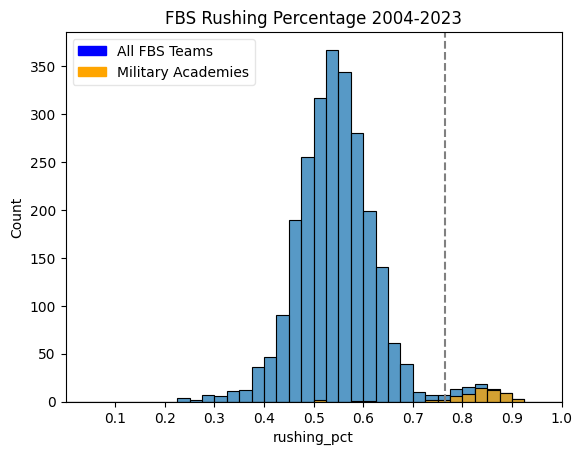

In [13]:
option_academy_season_df = season_df[
    ((season_df['team'] == 'Air Force')&(season_df['season'].isin(year_list+[2004,2005,2020])))|(
        (season_df['team'] == 'Army')&(season_df['season'].isin(year_list+[2004,2005,2020])))|(
            (season_df['team'] == 'Navy')&(season_df['season'].isin(year_list+[2004,2005,2020])))]

ax = sns.histplot(binwidth=0.025,binrange=(0,1),
                  data=season_df['rushing_pct'])
ax2 = sns.histplot(binwidth=0.025,binrange=(0,1), color='orange',
                   data=option_academy_season_df['rushing_pct'])

ax2.axvline(x=season_df['rushing_pct'].quantile(0.97),color='gray',ls='--')
ax2.set(xlim=(0,1),
        xticks=[i/10 for i in range(1,11)])

import matplotlib.patches as mpatches

handles=[mpatches.Patch(color='b',label='All FBS Teams'),
         mpatches.Patch(color='orange',label='Military Academies')]

plt.title("FBS Rushing Percentage 2004-2023")
plt.legend(handles=handles,framealpha=0.5)
plt.show()

In [14]:
'97th percentile, rushing_pct: ' + str(round(season_df['rushing_pct'].quantile(0.97), 3))

'97th percentile, rushing_pct: 0.764'

In [15]:
season_df['rushing_off'] = 0
season_df.loc[season_df['rushing_pct'] >= season_df['rushing_pct'].quantile(0.97), 'rushing_off'] = 1

In [16]:
rush_df = season_df[season_df['rushing_off']==1][['team','season']]
'# of Rushing Offenses: ' + str(len(rush_df))

'# of Rushing Offenses: 75'

The remainder of the analysis will focus on "Rushing Offenses", where a Rushing Offense is an offense with a season *rushing_pct* at or above the 97th percentile. 

"Rushing Offense" is a good, precise proxy for the rather nebulous and difficult-to-define "Option Offense" category. Some teams might have a high *rushing_pct* because of unusual circumstances during a specific season: maybe their quarterbacks get injured or they have especially great running backs. Schools with teams running Option offenses, on the other hand, will consistently have a high *rushing_pct* across multiple seasons: they run the Option because it's the offense their coach runs and / or they face institutional limitations. 

We can see this with the 75 Rushing Offenses in the sample when they're broken down by season. Besides Rice at the beginning of the timeline, schools with Rushing Offenses have them across multiple seasons. 

In [17]:
rush_df_display = pd.DataFrame(columns=sorted(rush_df['season'].unique()), index=rush_df['team'].unique())
for team in rush_df_display.index:
    rush_df_team = rush_df[rush_df['team']==team]
    for season in rush_df_display.columns:
        rush_df_display.loc[team, season] = ''
        if len(rush_df_team[rush_df_team['season']==season]) > 0:
            rush_df_display.loc[team, season] = 'X'
rush_df_display

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Air Force,X,,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X
Army,,,,,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X
Georgia Southern,,,,,,,,,,,X,X,,X,X,X,X,,,
Georgia Tech,,,,,X,X,X,X,X,X,X,,X,X,X,,,,,
Navy,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,
New Mexico,,,,,,,,,X,X,X,,X,,,,,,,
Rice,X,,,,,,,,,,,,,,,,,,,


There are some gaps (Air Force 2005, Georgia Southern 2016, Georgia Tech 2015, New Mexico 2015) because we set the cutoff at the 97th percentile. If the cutoff was lowered to the 96th percentile, each of these teams would also be included, but so would many one-off teams that don't really meet the criteria we're looking for.

With a set of Rushing Offenses in hand, we indicate whether each game includes a Rushing Offense for the home team and/or away team. 

In [18]:
games_df = games_df.merge(rush_df,
                          left_on=['home_team','season'],
                          right_on=['team','season'],
                          how='left', indicator='home_rushing_team')
games_df['home_rushing_team'] = games_df['home_rushing_team'].eq('both')
games_df = games_df.drop(columns='team')

games_df = games_df.merge(rush_df,
                          left_on=['away_team','season'],
                          right_on=['team','season'],
                          how='left', indicator='away_rushing_team')
games_df['away_rushing_team'] = games_df['away_rushing_team'].eq('both')

games_df = games_df.drop(columns='team')

# 4. Experience <a name="experience">

The previous section refined our question a bit: does prior experience defending Rushing Offenses improves a defense’s performance against them? We now need to get clear on what we mean by *experience* against Rushing Offenses. 

We can distinguish two ways a defense gains experience against Rushing Offenses:

  1. Recently playing games against Rushing Offenses.
  2. Having a Rushing Offense on their own team.

## 4.1. Recent Games

If a defense has recently played against a Rushing Offense, the players and coaches who were with the team at the time should be able to build on their previous preparation when getting ready to face more Rushing Offenses. They also should be able to learn from those previous games to improve their tactics. This can build up institutional knowledge about how to prepare for and play against Rushing Offenses that helps the players and coaches who weren't around for those previous games.

We define a defense's *Game Experience Score* (GES) heading into each game. For a given game and defense, the defense's Game Experience Score is the number of games the defense has played against Rushing Offenses in the 2 prior seasons and the current season before the current game. A 2-season cutoff for Game Experience seems reasonable because we can reasonably expect that many important players (Juniors and Seniors) and coaches were with the team for the games in that window.

Below, we go through each game and calculate the GES for the home and away teams. The printed example shows Notre Dame's GES in games against Rushing Teams during the 2009-2011 seasons. Going into the 2011 Week 6 matchup against Air Force, ND had a GES of 3 because of the 2009 Navy, 2010 Navy, and 2010 Army games. Going into the 2011 Week 9 matchup against Navy, ND had a GES of 4 because of the 3 games in 2009-2010 plus the Air Force game earlier that season.  

In [19]:
n_years = 2 # number of years back to count Game Experience

In [20]:
games_df['home_experience'] = 0
games_df['away_experience'] = 0

In [21]:
for i, row in games_df[games_df['season'].isin(year_list)].iterrows():
    home = row['home_team']
    away = row['away_team']
    
    season = row['season']
    week = row['week']
    
    games_df1 = games_df[(games_df['season']<=season)&(games_df['season']>=season-n_years)]
    
    # Input home team Game Experience
    home_experience = len(games_df1[((games_df1['season']<season)|(
        (games_df1['season']==season)&(games_df1['week']<week)))&(((games_df1['home_team']==home)&(
            games_df1['away_rushing_team']==True))|((games_df1['away_team']==home)&(
            games_df1['home_rushing_team']==True)))])
    games_df.loc[i, 'home_experience'] = home_experience
    
    # Input away team Game Experience
    away_experience = len(games_df1[((games_df1['season']<season)|(
        (games_df1['season']==season)&(games_df1['week']<week)))&(((games_df1['home_team']==away)&(
            games_df1['away_rushing_team']==True))|((games_df1['away_team']==away)&(
            games_df1['home_rushing_team']==True)))])
    games_df.loc[i, 'away_experience'] = away_experience
    
    # Print example
    if (home=='Notre Dame')&(season==2011)&(week==9):
        print(games_df.loc[games_df1[(games_df1['season']<=season)&(((games_df1['home_team']==home)&(
            games_df1['away_rushing_team']==True))|((games_df1['away_team']==home)&(
            games_df1['home_rushing_team']==True)))].index,
            ['home_team','away_team','season','week','home_experience','away_experience']])

       home_team   away_team  season  week  home_experience  away_experience
4242  Notre Dame        Navy    2009    10                3                4
4891        Navy  Notre Dame    2010     8                5                2
5140  Notre Dame        Army    2010    12                3                5
5578  Notre Dame   Air Force    2011     6                3                5
5733  Notre Dame        Navy    2011     9                4                5


Before discussing the second way a defense gains experience against Rushing Offenses, we'll do some more preprocessing. Using GES as a measure of experience forces us to truncate the dataset. Since we only have team season statistics going back to 2004, we can only calculate the GES starting in 2006, since this calculation requires us to find Rushing Offenses on the schedule in the previous two years. As a result, game and PBP data from 2004 and 2005 are discarded for the final analysis. We also discard data from the pandemic-disrupted 2020 season.

In [22]:
games_df = games_df[games_df['season'].isin(year_list)] # year_list = [2006, ..., 2023] without 2020.
team_df = team_df[team_df['season'].isin(year_list)]

Next, we discard game and PBP data from games that featured non-FBS teams. These games are generally uncompetitive, data on non-FBS teams is less reliable, and including them would just complicate the analysis to little benefit. 

In [23]:
for year in year_list: # non-FBS away teams
    team_list = team_df.loc[team_df['season']==year, 'school'].to_list()
    games_df_year = games_df[games_df['season']==year]  
    PBP_df_year = PBP_df[PBP_df['season']==year]
    
    games_df = games_df.drop(games_df_year[~games_df_year['away_team'].isin(team_list)].index)
    PBP_df = PBP_df.drop(PBP_df_year[~PBP_df_year['away'].isin(team_list)].index)
games_df = games_df.reset_index(drop=True)
PBP_df = PBP_df.reset_index(drop=True)

for year in year_list: # non-FBS home teams
    team_list = team_df.loc[team_df['season']==year, 'school'].to_list()
    games_df_year = games_df[games_df['season']==year]  
    PBP_df_year = PBP_df[PBP_df['season']==year]
    
    games_df = games_df.drop(games_df_year[~games_df_year['home_team'].isin(team_list)].index)
    PBP_df = PBP_df.drop(PBP_df_year[~PBP_df_year['home'].isin(team_list)].index)
games_df = games_df.reset_index(drop=True)
PBP_df = PBP_df.reset_index(drop=True)

It will be convenient to create a team key with a school name / season string. 

In [24]:
team_df['school'] = team_df['school'] + team_df['season'].astype(str)

games_df['home_team'] = games_df['home_team'] + games_df['season'].astype(str)
games_df['away_team'] = games_df['away_team'] + games_df['season'].astype(str)

PBP_df['home'] = PBP_df['home'] + PBP_df['season'].astype(str)
PBP_df['away'] = PBP_df['away'] + PBP_df['season'].astype(str)

PBP_df['offense'] = PBP_df['offense'] + PBP_df['season'].astype(str)
PBP_df['defense'] = PBP_df['defense'] + PBP_df['season'].astype(str)

season_df['team'] = season_df['team'] + season_df['season'].astype(str)
season_df = season_df.set_index('team')

rushing_teams = list(season_df.loc[(season_df['season'].isin(year_list))&(season_df['rushing_off']==1)].index)

We add a variable to the PBP data indicating whether the offense for a given play is a Rushing Offense.

In [25]:
PBP_df = PBP_df.join(season_df[['rushing_off']], on='offense')

Finally, we add the Game Experience Scores from the game data to the PBP data and create a variable specifically for the defense's GES on a given play.

In [26]:
PBP_df = PBP_df.merge(games_df[['id','home_experience','away_experience']], 
                      left_on='game_id', right_on='id', suffixes=(None, "_temp"))
PBP_df['defense_GES'] = (PBP_df['away']==PBP_df['offense'])*PBP_df['home_experience'] + (
    PBP_df['home']==PBP_df['offense'])*PBP_df['away_experience']

For plays with a rushing offense, the most common defense GES is 2, followed by 1 and 0. GES above 5 is rare. For plays without a rushing offense, on the other hand, the most common defense GES is 0 by a wide margin.

In [27]:
temp = PBP_df[['defense_GES','rushing_off','away']].pivot_table(
    index='defense_GES', columns='rushing_off', aggfunc='count', fill_value=0)
temp.columns = temp.columns.droplevel()
temp/temp.sum()

rushing_off,0,1
defense_GES,,
0,0.610052,0.191036
1,0.158930,0.225195
2,0.129425,0.298514
3,0.061790,0.110498
4,0.024961,0.094330
5,0.010869,0.056649
6,0.002758,0.017756
7,0.000667,0.004923
8,0.000364,0.001101


## 4.2. Own Team

If a team has a Rushing Offense, we'd expect that team's defense to be better prepared to face other Rushing Offenses. We add a variable to the PBP data indicating whether the defense for a given play has a Rushing Offense on its team.

In [28]:
PBP_df['rushing_team_def'] = 0
PBP_df.loc[PBP_df['defense'].isin(rushing_teams), 'rushing_team_def'] = 1

Of the plays with a Rushing Offense, 13.2% were defended by a defense with another Rushing Offense on its team.

In [29]:
temp = PBP_df[['rushing_team_def', 'rushing_off', 'away']].pivot_table(
    index='rushing_team_def', columns='rushing_off', aggfunc='count', fill_value=0)
temp.columns = temp.columns.droplevel()
temp/temp.sum()

rushing_off,0,1
rushing_team_def,,
0,0.974888,0.868412
1,0.025112,0.131588


# 5. Performance <a name="performance">

We have precise definitions of Rushing Offenses and experience against them. The last ingredient we need is a measure of performance. The PBP data contains a *ppa* variable that's a good candidate. PPA, short for Predicted (or Expected) Points Added, is a measure of how a given play is expected to affect the scoring margin.[6](#6)

A positive PPA indicates a good play for the offense. For instance, in the play below from 2006, Texas Tech faced a 4th and 13 against SMU and rushed for 16 yards, gaining the first down and then some. This was a great result for the offense, a fact that's reflected in the high PPA of 3.39.

In [30]:
PBP_df.loc[PBP_df['id']==262452641031, ['offense','defense', 'yard_line', 'down',
                                'distance', 'yards_gained', 'play_type','ppa']]

,offense,defense,yard_line,down,distance,yards_gained,play_type,ppa
6000,Texas Tech2006,SMU2006,64,4,13,16,Rush,3.386074


Conversely, a negative PPA indicates a good play for the defense. In the play below from 2007, Arkansas had a 1st and 10 against South Carolina and rushed for only 1 yard. This was a pretty good result for the defense, which is reflected in the somewhat low PPA of -0.82.

In [31]:
PBP_df.loc[PBP_df['id']==273070008173, ['offense','defense', 'yard_line', 'down',
                                'distance', 'yards_gained', 'play_type','ppa']]

,offense,defense,yard_line,down,distance,yards_gained,play_type,ppa
180009,Arkansas2007,South Carolina2007,53,1,10,1,Rush,-0.81639


Using PPA as our performance measure, the goal is now to test whether a defense's prior experience against Rushing Offenses has an impact on PPA when playing against them.

We drop plays with null PPA as well as special teams plays like punts and kickoffs, leaving us with 1,582,844 plays in the dataset. The mean PPA is 0.127 with a standard deviation of 1.226. 

In [32]:
PBP_df = PBP_df.dropna(subset=['ppa'])

In [33]:
drop_play_types = ['Punt Return Touchdown','Blocked Punt Touchdown','Blocked Field Goal Touchdown',
                   'Kickoff Return Touchdown','placeholder','Field Goal Good']
PBP_df = PBP_df[~PBP_df['play_type'].isin(drop_play_types)]
PBP_df = PBP_df.reset_index(drop=True)

In [34]:
pd.DataFrame(PBP_df['ppa'].describe())

,ppa
count,1.582844e+06
mean,1.265052e-01
std,1.225548e+00
min,-1.278676e+01
25%,-5.835822e-01
50%,-1.308110e-01
75%,6.980426e-01
max,7.382809e+00


# 6. Model Construction <a name="model">

We analyze the effect of prior experience on performance against Rushing Offenses using a linear regression model. The model assumes that PPA on a given play can be estimated as a linear combination of the following variables:

 * *Offense strength*: how good the offense is.
 * *Defense strength*: how good the defense is.
 * *Home-field advantage (hfa)*: whether the offense or defense (or neither in the case of a neutral-site game) is playing at home.
 * *Defense GES x Rushing Offense*: an interaction term that equals the defense's GES when the play involves a Rushing Offense and 0 otherwise.
 * *Rushing Team Defense x Rushing Offense*: an interaction term that equals 1 when the offense is a Rushing Offense and the defense has another Rushing Offense on its team, and 0 otherwise.
 
$$(2) \quad \text{ppa ~ offense strength + defense strength + hfa}\\ \text{ + defense_GES_x_rushing_off}\\ \text{+ rushing_team_def_x_rushing_off}.$$

We're primarily in the estimates of the coefficients on the two interaction terms. If prior experience against Rushing Offenses improves performance against them, one or both of these coefficients should be negative (since lower PPA indicates better defensive performance). We add them to the PBP data.

In [35]:
PBP_df['defense_GES_x_rushing_off'] = PBP_df['defense_GES']*PBP_df['rushing_off']
PBP_df['rushing_team_def_x_rushing_off'] = PBP_df['rushing_team_def']*PBP_df['rushing_off']

We also add the *hfa* variable to the PBP data indicating whether the offense, defense, or neither has the home-field advantage.

In [36]:
neutralGames = games_df['id'][games_df['neutral_site']==True].to_list()
PBP_df['hfa'] = None # homefield advantage
PBP_df.loc[PBP_df['home'] == PBP_df['offense'], 'hfa'] = 1 # home team on offense
PBP_df.loc[PBP_df['home'] == PBP_df['defense'], 'hfa'] = -1 # away team on offense
PBP_df.loc[PBP_df['game_id'].isin(neutralGames), 'hfa'] = 0 # neutral site games

We isolate the variables needed to construct the model.

In [37]:
df = PBP_df[['offense', 'defense', 'rushing_off', 
             'defense_GES', 'defense_GES_x_rushing_off', 
             'rushing_team_def', 'rushing_team_def_x_rushing_off',
             'hfa', 'ppa']].dropna(subset='ppa')

To estimate offensive and defensive strength, we create dummy variables for each offense and defense. Offenses with higher coefficients are stronger, while defenses with lower coefficients are stronger.

In [38]:
dummies_df = pd.get_dummies(df[['offense', 'defense', 'hfa',# 'defense_GES',
    'defense_GES_x_rushing_off', 'rushing_team_def_x_rushing_off']], 
    columns=['offense', 'defense'], sparse=True)

In [39]:
dummies_df

,hfa,defense_GES_x_rushing_off,rushing_team_def_x_rushing_off,offense_Air Force2006,offense_Air Force2007,offense_Air Force2008,offense_Air Force2009,offense_Air Force2010,offense_Air Force2011,offense_Air Force2012,...,defense_Wyoming2013,defense_Wyoming2014,defense_Wyoming2015,defense_Wyoming2016,defense_Wyoming2017,defense_Wyoming2018,defense_Wyoming2019,defense_Wyoming2021,defense_Wyoming2022,defense_Wyoming2023
0,-1,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-1,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582839,0,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1582840,0,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1582841,0,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1582842,0,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The resulting matrix is huge (1,582,844 x 4275) but is also sparse, with most entries equal to zero. We use scipy's sparse matrix tools to make the calculations more tractable, populating a lil_matrix with the values from *dummies_df* before converting it to CSR format.[7](#7)

In [40]:
dummies_df[['rushing_team_def_x_rushing_off']] = dummies_df[[
    'rushing_team_def_x_rushing_off']].astype(pd.SparseDtype("bool", False))

In [41]:
dummies_df[['hfa', 'defense_GES_x_rushing_off']] = dummies_df[[
    'hfa', 'defense_GES_x_rushing_off']].astype(pd.SparseDtype("int8", 0))

In [42]:
arr = lil_matrix(dummies_df.shape, dtype=np.int8)

In [43]:
# defense_GES_x_rushing_off, hfa, defense_GES
for i in range(2):
    print(dummies_df.columns[i])
    ix = dummies_df[dummies_df.columns[i]] != 0
    arr[np.where(ix), i] = dummies_df.loc[ix, dummies_df.columns[i]]

hfa
defense_GES_x_rushing_off


In [44]:
# team dummies
for i in range(2, len(dummies_df.columns)):
    ix = dummies_df[dummies_df.columns[i]] != 0
    arr[np.where(ix), i] = 1

In [45]:
arr = arr.tocsr()

# 7. Model Training and Results <a name="training">

We use sklearn to fit a linear regression model to the data before displaying the important results.

In [46]:
reg = linear_model.LinearRegression(fit_intercept=True) 
reg.fit(X=arr, y=df['ppa'])

LinearRegression()

In [47]:
# Extract regression coefficients
reg_results_df = pd.DataFrame({
    'coef_name': dummies_df.columns.values,
    'reg_coef': reg.coef_})
reg_results_df.loc[len(reg_results_df.index)] = ['Intercept', reg.intercept_]

reg_results_df.loc[reg_results_df['coef_name'].isin([
    'hfa', 'defense_GES_x_rushing_off',
    'rushing_team_def_x_rushing_off', 'Intercept'])].round(4)

,coef_name,reg_coef
0,hfa,0.0108
1,defense_GES_x_rushing_off,-0.0171
2,rushing_team_def_x_rushing_off,-0.0879
4275,Intercept,0.1233


As expected, the coefficients on both experience variables, *Defense GES x Rushing Offense* and *Rushing Team Defense x Rushing Offense*, are negative. On plays with a Rushing Offense, the expected PPA:

 * decreases by 0.0171 with each additional game the defense has played recently against Rushing Offenses, and
 * decreases by 0.0879 if the defense has a Rushing Offense on its team.

It's reasonable to expect a Rushing Offense to get about 65 plays per game,[8](#8) so these amount to decreases of 1.11 and 5.71 PPA over the course of a game.

# 8. Bootstrap Confidence Intervals <a name="bootstrap">

To get a sense of how robust this result is, we should construct confidence intervals on these estimates. Bootstrap sampling is a good method here because it doesn't assume that the model errors follow any particular distribution. Standard methods of constructing confidence intervals on model parameters assume normally distributed errors, but we can see that this assumption doesn't hold for our model.

In [48]:
y_hat = reg.predict(arr)
res = df['ppa'] - y_hat

df['y_hat'] = y_hat
df['res'] = res

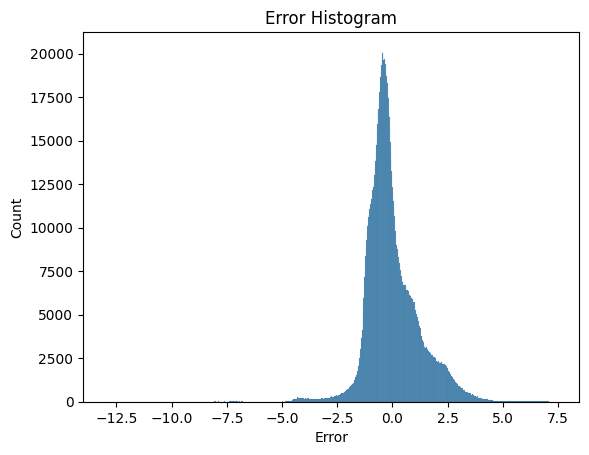

In [49]:
ax = sns.histplot(data=df, x='res')

ax.set_title('Error Histogram')
ax.set_xlabel('Error')

plt.show()
plt.close()

Bootstrap sampling resamples the dataset (with replacement) a number of times. For each sample, we fit the model and keep track of the resulting parameter estimates. The bootstrap estimates of a parameter $\beta$ can give us a confidence interval on that parameter. To get a 95% confidence interval on $\beta$, we find the 0.025 and 0.975 percentiles of the bootstrap sample estimates of $\beta$.

We take 1000 bootstrap samples and print the results for the variables of interest.

In [50]:
def bootstrap_sample(X, y, n_samples, seed=1):
    np.random.seed(seed)
    size = len(y)
    indices = [i for i in range(size)]
    bootstrap_coefs = []
    for _ in range(n_samples):
        bootstrap_indices = np.random.choice(indices, size=size, replace=True)
        X_sample = X[bootstrap_indices]
        y_sample = y[bootstrap_indices]
        
        reg = linear_model.LinearRegression(fit_intercept=True) 
        reg.fit(X=X_sample, y=y_sample)
        
        bootstrap_coefs.append(reg.coef_)
        
    return np.array(bootstrap_coefs)

In [51]:
bootstrap_coefs = bootstrap_sample(arr, df['ppa'], n_samples=1000)

In [52]:
bootstrap_experience_coefs = bootstrap_coefs[:, 1]

In [53]:
bootstrap_info = []
for i in range(3):
    bootstrap_coefs_i = bootstrap_coefs[:, i]
    col_i = dummies_df.columns[i]
    mean = np.mean(bootstrap_coefs_i)
    low_quantile = np.quantile(bootstrap_coefs_i, 0.025)
    high_quantile = np.quantile(bootstrap_coefs_i, 0.975)
    
    bootstrap_info.append([col_i, round(mean, 4), [round(low_quantile, 4), round(high_quantile, 4)]])

pd.DataFrame(bootstrap_info, columns=['Variable', 'Bootstrap mean', '95% bootstrap interval'])

,Variable,Bootstrap mean,95% bootstrap interval
0,hfa,0.0108,"[0.0088, 0.013]"
1,defense_GES_x_rushing_off,-0.0170,"[-0.0259, -0.0075]"
2,rushing_team_def_x_rushing_off,-0.0882,"[-0.1331, -0.0437]"


For *Defense GES x Rushing Offense*, the 95% bootstrap confidence interval is [-0.0259, -0.0075], and for *Rushing Team Defense x Rushing Offense*, the 95% bootstrap confidence interval is [-0.1331, -0.0437]. Both intervals stop well short of zero, so the negative coefficient estimate result seems to be robust given the model specification.

# 9. Discussion <a name="discussion">

We started with the question of whether prior experience with Option Offenses improves a defense’s performance. We refined that to the question of whether Game or Own-Team experience with Rushing Offenses improves a defense's PPA allowed. We constructed a linear regression model that gives an affirmative answer for both types of experience.

Regression models of complex processes generally come with the potential for estimation bias introduced by model misspecification. With only 5 independent variables, our model is likely too simple to capture every important factor affecting PPA. Omitting variables that are correlated with both the regressors and the dependent variable can bias the coefficient estimates. Our analysis faces the risk of a false positive if we omitted some variable(s) correlated with both experience and PPA whose omission biased the coefficient estimates downward.

## 9.1. Adding Complexity

While we can't make this concern go away fully, we can at least see what happens if we add some unused variables from the dataset to the model.

### 9.1.1. Period

Periods range from 0 to 11, with 0 likely being data errors. We group all non-regulation periods (not in 1-4) together with period 5 for a general "overtime" category. This gets rid of sparsely populated categories for when we create dummy variables.

In [54]:
pd.DataFrame(PBP_df['period'].value_counts())

,count
period,
2,420118
4,396740
1,382651
3,378189
5,4515
6,436
7,99
8,42
0,36


In [55]:
PBP_df['period_trunc'] = PBP_df['period']
PBP_df.loc[~PBP_df['period'].isin([1,2,3,4,5]), 'period_trunc'] = 5

Below, we see that mean PPA varies with the period. It's lower in overtime than it is in the 4th quarter, which is lower than the first 3 quarters. There also appears to be an interaction effect with Rushing Offenses, which outperform other offenses in regulation but not overtime.

In [56]:
PBP_df.groupby(['period_trunc','rushing_off'])[['ppa']].mean()

ppa
period_trunc rushing_off          
1            0            0.150206
             1            0.210621
2            0            0.130158
             1            0.181691
3            0            0.143942
             1            0.211982
4            0            0.079226
             1            0.113120
5            0           -0.059520
             1           -0.090001

### 9.1.2. Down

Mean PPA varies with the down, 3rd downs having the highest mean PPA and 1st downs having the lowest. There again appears to be an interaction with Rushing Offenses, which slightly outperform other offenses on 1st through 3rd downs but greatly outperform on 4th down. This is unsurprising since most 4th downs are rushing plays.

In [57]:
PBP_df.groupby(['down','rushing_off'])[['ppa']].mean()

ppa
down rushing_off          
1    0           -0.005040
     1            0.042829
2    0            0.105529
     1            0.142021
3    0            0.439912
     1            0.472730
4    0            0.091681
     1            0.437262

### 9.1.3. Yards to Goal

PPA increases as the yards to the goal line at the beginning of the play increases. The association is slightly weaker for Rushing Offenses, but probably not by enough to warrant an interaction term in the model.

In [58]:
np.corrcoef(PBP_df.loc[PBP_df['rushing_off']==0, 'yards_to_goal'], PBP_df.loc[PBP_df['rushing_off']==0, 'ppa'])

array([[1.        , 0.08941935],
       [0.08941935, 1.        ]])

In [59]:
np.corrcoef(PBP_df.loc[PBP_df['rushing_off']==1, 'yards_to_goal'], PBP_df.loc[PBP_df['rushing_off']==1, 'ppa'])

array([[1.        , 0.07240664],
       [0.07240664, 1.        ]])

### 9.1.4. Specifying, Fitting, and Bootstrapping a New Model

We'll add terms for the following variables to the model:

 * *down* (4 dummy variables)
 * *4th down x Rushing Offense*
 * *period* (5 dummy variables)
 * *period 5+ x Rushing Offense*
 * *yards to goal*

We'll also add *defense_GES*, which gives the defense's Game Experience Score regardless of whether they're facing a Rushing Offense.

In [60]:
PBP_df['down_4_x_rushing_off'] = (PBP_df['down']==4)*PBP_df['rushing_off'] # new
PBP_df['period_trunc_5_x_rushing_off'] = (PBP_df['period_trunc']==5)*PBP_df['rushing_off'] # new

In [61]:
df1 = PBP_df[['offense', 'defense', 
              'rushing_off', 
              'defense_GES',
              'defense_GES_x_rushing_off', 
              'rushing_team_def',
              'rushing_team_def_x_rushing_off',
              'down', # new              
              'down_4_x_rushing_off', # new
              'period_trunc', # new
              'period_trunc_5_x_rushing_off', # new
              'yards_to_goal', # new
              'hfa', 'ppa']].dropna(subset='ppa')

In [62]:
dummies_df1 = pd.get_dummies(df1[[
    'down', # new
    'period_trunc', # new
    'offense', 'defense', 'hfa',
    'defense_GES', # new
    'defense_GES_x_rushing_off',
    'yards_to_goal', # new
    'rushing_team_def_x_rushing_off',
    'down_4_x_rushing_off', # new
    'period_trunc_5_x_rushing_off' # new
]],  columns=['down', 'period_trunc', 'offense', 'defense'], sparse=True)

In [63]:
dummies_df1

,hfa,defense_GES,defense_GES_x_rushing_off,yards_to_goal,rushing_team_def_x_rushing_off,down_4_x_rushing_off,period_trunc_5_x_rushing_off,down_1,down_2,down_3,...,defense_Wyoming2013,defense_Wyoming2014,defense_Wyoming2015,defense_Wyoming2016,defense_Wyoming2017,defense_Wyoming2018,defense_Wyoming2019,defense_Wyoming2021,defense_Wyoming2022,defense_Wyoming2023
0,-1,1,0,80,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-1,1,0,44,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,1,0,43,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,1,0,57,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,1,0,39,0,0,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582839,0,5,0,83,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1582840,0,5,0,94,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1582841,0,5,0,94,0,0,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1582842,0,5,0,94,0,0,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False


We again need to convert the model inputs to scipy's CSR format for sparse matrices.

In [64]:
dummies_df1[['rushing_team_def_x_rushing_off', 'down_4_x_rushing_off',
    'period_trunc_5_x_rushing_off']] = dummies_df1[[
    'rushing_team_def_x_rushing_off','down_4_x_rushing_off',
     'period_trunc_5_x_rushing_off']].astype(pd.SparseDtype("bool", False))

In [65]:
dummies_df1[['hfa', 'defense_GES', 'defense_GES_x_rushing_off', 'yards_to_goal']] = dummies_df1[[
    'hfa', 'defense_GES', 'defense_GES_x_rushing_off', 'yards_to_goal']].astype(
    pd.SparseDtype("int8", 0))

In [66]:
arr1 = lil_matrix(dummies_df1.shape, dtype=np.int8)

In [67]:
# hfa, defense_GES, defense_GES_x_rushing_off, yards_to_goal
for i in range(4): # 
    print(dummies_df1.columns[i])
    ix = dummies_df1[dummies_df1.columns[i]] != 0
    arr1[np.where(ix), i] = dummies_df1.loc[ix, dummies_df1.columns[i]]

hfa
defense_GES
defense_GES_x_rushing_off
yards_to_goal


In [68]:
# team, down, period dummies
for i in range(4, len(dummies_df1.columns)):
    ix = dummies_df1[dummies_df1.columns[i]] != 0
    arr1[np.where(ix), i] = 1

In [69]:
arr1 = arr1.tocsr()

We train the new model and display the important parameter estimates.

In [70]:
reg1 = linear_model.LinearRegression(fit_intercept=True) 
reg1.fit(X=arr1, y=df1['ppa'])

LinearRegression()

In [71]:
# Extract regression coefficients
reg_results_df1 = pd.DataFrame({
    'coef_name': dummies_df1.columns.values,
    'reg_coef': reg1.coef_})
reg_results_df1.loc[len(reg_results_df1.index)] = ['Intercept', reg1.intercept_]

reg_results_df1.loc[reg_results_df1['coef_name'].isin([
    'hfa', 
    'defense_GES', 'defense_GES_x_rushing_off',
    'rushing_team_def_x_rushing_off', 
    'yards_to_goal',
    'down_1','down_2','down_3','down_4',
    'down_4_x_rushing_off',
    'period_trunc_5_x_rushing_off',
    'period_trunc_1','period_trunc_2','period_trunc_3','period_trunc_4','period_trunc_5',
    'Intercept'])].round(4)

,coef_name,reg_coef
0,hfa,0.0142
1,defense_GES,0.0165
2,defense_GES_x_rushing_off,-0.0246
3,yards_to_goal,0.0056
4,rushing_team_def_x_rushing_off,-0.0986
5,down_4_x_rushing_off,0.2799
6,period_trunc_5_x_rushing_off,-0.0795
7,down_1,-0.2049
8,down_2,-0.0786
9,down_3,0.2711


Moving to the more complex model has actually *decreased* the important experience coefficients: from -0.0171 to -0.0246 for GES x Rushing Offense and from -0.0879 to -0.0986 for Own-Team experience. We'll look at bootstrap confidence intervals (1000 samples) for the new model in case the added variables decrease the efficiency of the parameter estimates.

In [72]:
bootstrap_coefs1 = bootstrap_sample(arr1, df1['ppa'], n_samples=1000)

In [73]:
bootstrap_experience_coefs1 = bootstrap_coefs1[:, 1]

In [74]:
bootstrap_info1 = []
for i in range(16):
    bootstrap_coefs_i = bootstrap_coefs1[:, i]
    col_i = dummies_df1.columns[i]
    mean = np.mean(bootstrap_coefs_i)
    low_quantile = np.quantile(bootstrap_coefs_i, 0.025)
    high_quantile = np.quantile(bootstrap_coefs_i, 0.975)
    
    bootstrap_info1.append([col_i, round(mean, 4), [round(low_quantile, 4), round(high_quantile, 4)]])

pd.DataFrame(bootstrap_info1, columns=['Variable', 'Bootstrap mean', '95% bootstrap interval'])

,Variable,Bootstrap mean,95% bootstrap interval
0,hfa,0.0142,"[0.0121, 0.0163]"
1,defense_GES,0.0165,"[0.0135, 0.0193]"
2,defense_GES_x_rushing_off,-0.0245,"[-0.0336, -0.0154]"
3,yards_to_goal,0.0056,"[0.0055, 0.0057]"
4,rushing_team_def_x_rushing_off,-0.0988,"[-0.1409, -0.0553]"
5,down_4_x_rushing_off,0.2787,"[0.1742, 0.392]"
6,period_trunc_5_x_rushing_off,-0.0821,"[-0.2294, 0.0645]"
7,down_1,-0.2050,"[-0.2116, -0.1981]"
8,down_2,-0.0787,"[-0.0854, -0.0725]"
9,down_3,0.2710,"[0.2638, 0.2782]"


For *Defense GES x Rushing Offense*, the 95% bootstrap confidence interval is [-0.0336, -0.0154], and for *Rushing Team Defense x Rushing Offense*, the 95% bootstrap confidence interval is [-0.1409, -0.0553]. Again, both intervals stop well short of zero.

# 10. Further Research <a name="further">

As discussed in the previous section, one way to explore this topic further is to check whether the result still holds if other relevant variables are found and added to the model. 

We could also look at more sophisticated measures of experience. For instance, the GES as defined in this project doesn't take coaching changes or player turnover into account. If a school hires a new coaching staff that brings in a bunch of transfer players, the school's experience against Rushing Offenses from previous years seems much less relevant. 

It's possible that some of the relationships between the independent variables and PPA are non-linear. We'll look at a bar plot of the most recent model errors by *Defense GES x Rushing Offense* (truncated to group values $\geq 5$ together).

In [75]:
df1['defense_GES_x_rushing_off_trunc'] = df1['defense_GES_x_rushing_off']
df1.loc[df1['defense_GES_x_rushing_off_trunc'] > 5, 'defense_GES_x_rushing_off_trunc'] = 5

In [77]:
y_hat1 = reg1.predict(arr1)
res1 = df1['ppa'] - y_hat1

df1['y_hat'] = y_hat1
df1['res'] = res1

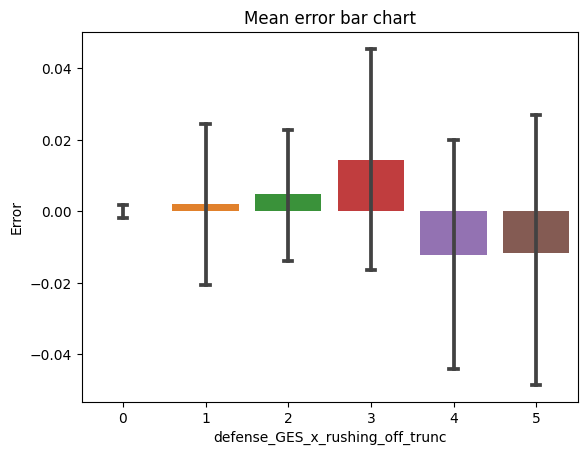

In [78]:
sns.barplot(df1, x='defense_GES_x_rushing_off_trunc', y='res', capsize=0.1)

plt.title('Mean error bar chart')
plt.ylabel('Error')

plt.show()
plt.close()

There's some evidence of non-linearity here. The mean error for GES 1-3 is positive while the mean error for GES 4+ is negative. A negative error means that the model overestimates the true PPA, which means that the model underestimates the performance of the defense. Since the error for GES 4+ is negative, it's possible that the model underestimates how much a defense benefits from having *lots* of recent Game Experience against Rushing Offenses.

# 11. References <a name="references">

[1] https://web3.ncaa.org/directory/memberList?type=12&division=I-FBS&sportCode=MFB <a name="1">

[2] http://fs.ncaa.org/Docs/AMA/Division%20I%20Forms/2010-11%20FBS%20Forms/Football%20Bowl%20Subqa%2012%208%2010.pdf<a name="2">

[3] https://www.defense.gov/News/Releases/Release/Article/2683495/statement-by-secretary-of-defense-lloyd-j-austin-iii-on-the-nfl-waiver-for-came/<a name="3">

[4] https://nflbreakdowns.com/2015/08/the-flexbone-option-offense-introduction/<a name="4">

[5] https://247sports.com/college/smu/Article/Army-Navy-game-2021-triple-option-what-makes-it-difficult-to-defend-177772816/<a name="5">

[6] https://collegefootballdata.com/glossary<a name="6">

[7] https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html<a name="7">
    
[8] https://www.teamrankings.com/college-football/stat/plays-per-game<a name="8">